In [1]:
import pandas as pd
import seaborn as sns
from collections import OrderedDict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as sc

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [4]:
df= df.drop(columns=["sex","children","smoker","region"],axis=1)

In [5]:
def custom_summary(df):
    result =[]
    for col in list(df.columns):
        stats = OrderedDict({"featureName":col,
                            "count":df[col].count(),
                            "datatype":df[col].dtype,
                            "min":df[col].min(),
                            "Q1":df[col].quantile(0.25),
                            "Q2":df[col].quantile(0.5),
                            "Q3":df[col].quantile(0.75),
                            "Q4":df[col].quantile(1.0),
                            "mean":df[col].mean(),
                            "stdv":df[col].std(),
                            "var":df[col].var(),
                            "kurt":df[col].kurt(),
                            "skew":df[col].skew(),
                            "range":df[col].min() - df[col].max(),
                            "IQR": df[col].quantile(0.75) - df[col].quantile(0.25)
                            })
        if df[col].skew()<-1.0:
            label = "Highly negatively skewed"
        elif -1.0<df[col].skew()<-0.5:
            label = "moderately negatively skewed"
        elif -0.5<df[col].skew()<0.5:
            label = "fairly symmetric"
        elif -0.5<df[col].skew()<0.5:
            label = "moderately positively skewed"
        else:
            label = "Highly positively skewed"
            
        stats['skewness comment'] = label;
        
        #Outliers identification
        upper_limit = stats['Q3'] + (1.5*stats['IQR'])
        lower_limit = stats['Q1'] - (1.5*stats['IQR'])
        if len([x for x in df[col] if x <lower_limit or x>upper_limit ]) > 0:
            outliers_label = "Has outliers"
        else:
            outliers_label = "No outliers"
        
        stats['Outlier comment'] = outliers_label
        #count =0
        #if (x for x in df[col] if x <lower_limit) or (x for x in df[col] if x>upper_limit):
        #    count +=1
        
        stats['number of outliers'] = len([x for x in df[col] if x <lower_limit or x>upper_limit ])
        stats['Percentage of outliers'] = stats['number of outliers']*100/stats['count']
        
        result.append(stats)
    resultdf = pd.DataFrame(data=result)
    return resultdf
    

In [6]:
custom_summary(df)

,featureName,count,datatype,min,Q1,Q2,Q3,Q4,mean,stdv,var,kurt,skew,range,IQR,skewness comment,Outlier comment,number of outliers,Percentage of outliers
0,age,1338,int64,18.0000,27.00000,39.000,51.000000,64.00000,39.207025,14.049960,1.974014e+02,-1.245088,0.055673,-46.00000,24.000000,fairly symmetric,No outliers,0,0.000000
1,bmi,1338,float64,15.9600,26.29625,30.400,34.693750,53.13000,30.663397,6.098187,3.718788e+01,-0.050732,0.284047,-37.17000,8.397500,fairly symmetric,Has outliers,9,0.672646
2,charges,1338,float64,1121.8739,4740.28715,9382.033,16639.912515,63770.42801,13270.422265,12110.011237,1.466524e+08,1.606299,1.515880,-62648.55411,11899.625365,Highly positively skewed,Has outliers,139,10.388640


# Outlier treatment

In [7]:
#Outlier treatment methods
def otf(data, col, method = 'Quartile', strategy= 'Median'):
    coldata = data[col]
    
    if method == 'Quartile':
        median = coldata.median()
        Q1 = coldata.quantile(0.25)
        Q3 = coldata.quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + (1.5*IQR)
        lower_limit = Q1 - (1.5*IQR)
        
    elif method == 'std':
        colmean = coldata.mean()
        colstd = coldata.std()
        upper_limit = colmean + (2*colstd)
        lower_limit = colmean - (2*colstd)
        
    else:
        print('Invalid method')
             
    outlier = data.loc[(coldata < lower_limit) | (coldata > upper_limit), col]
    
    outlier_percentage = round(len(outlier)*100/len(data), 2)
    
    if len(outlier) == 0:
        print(f"{col} doesn't have any outliers")
    else:
        print(f"Total number of outliers in {col} is {len(outlier)}")
        print(f'Percentage of outliers in {col} data is {outlier_percentage}')
    
    if strategy == 'Median':
        data.loc[(coldata < lower_limit) | (coldata > upper_limit), col] = median
    elif strategy == "Mean":
        data.loc[(coldata < lower_limit) | (coldata > upper_limit), col] = colmean
    return data;
    

In [8]:
def odt_plots(df, col):
    fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,5))
    
    kwargs = {'fontsize':15, 'color':'black'}    #key word arguements
    
    #box plot with outliers
    sns.boxplot(df[col],ax=ax1,color = 'b')
    ax1.set_title('Box plot for '+col, **kwargs)
    ax1.set_xlabel('values', **kwargs)
    ax1.set_ylabel('Box distribution', **kwargs)
    
    #histogram with outliers
    sns.distplot(df[col],ax=ax2,color = 'r', fit=sc.norm)
    ax2.set_title('Histogram plot for '+col, **kwargs)
    ax2.set_xlabel('values', **kwargs)
    ax2.set_ylabel('Histrogram', **kwargs)
    
    #histogram with no outliers
    y = otf(df,col)
    sns.distplot(y[col], ax = ax3, color = 'y', fit=sc.norm)
    plt.show()
    
    

age doesn't have any outliers


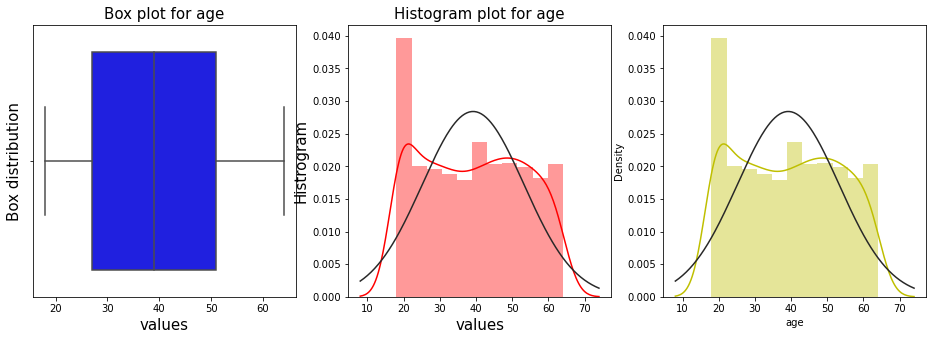

Total number of outliers in bmi is 9
Percentage of outliers in bmi data is 0.67


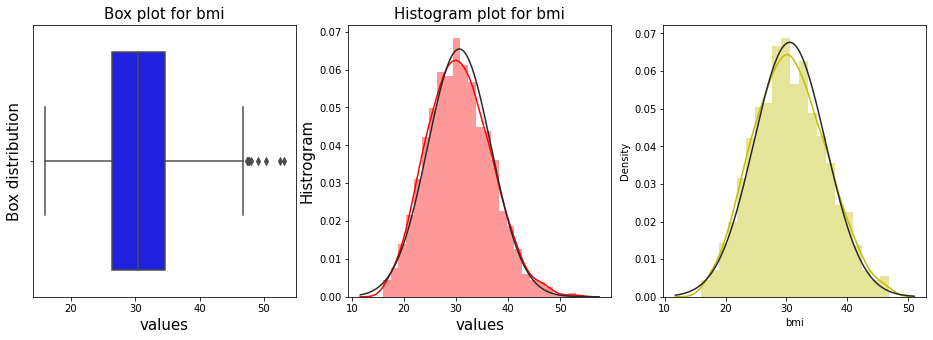

Total number of outliers in charges is 139
Percentage of outliers in charges data is 10.39


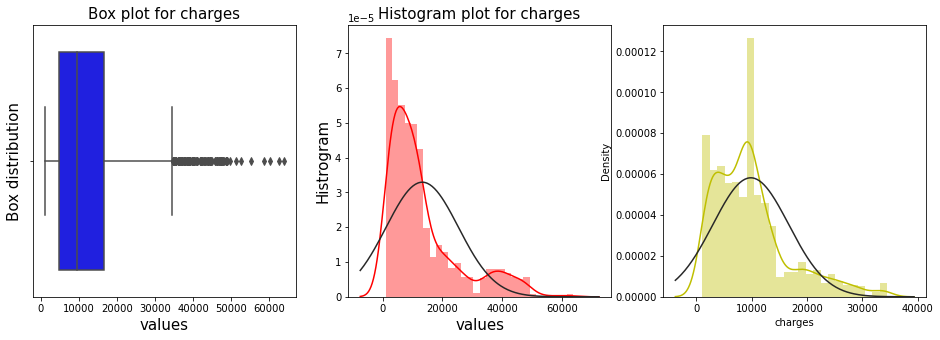

In [9]:
for col in df.columns:
    odt_plots(df, col)